<a href="https://colab.research.google.com/github/MilindiSenevirathne/COVID-19_Test/blob/main/COVID_19_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import geopandas as gpd

In [2]:
gdf =gpd.read_file('/content/sample_data/COVID-19_Cases_US.csv')
gdf.head()

,X,Y,OBJECTID,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Recovered,...,Active,Admin2,FIPS,Combined_Key,Incident_Rate,People_Tested,People_Hospitalized,UID,ISO3,geometry
0,-86.64408227,32.53952745,1,Alabama,US,2023/03/10 13:21:02+00,32.53952745,-86.64408227,19790,,...,,Autauga,01001,"Autauga, Alabama, US",35422.148239632,,,84001001,USA,None
1,-87.72207058,30.7277499100001,2,Alabama,US,2023/03/10 13:21:02+00,30.72774991,-87.72207058,69860,,...,,Baldwin,01003,"Baldwin, Alabama, US",31294.5160683408,,,84001003,USA,None
2,-85.3871286,31.8682630000001,3,Alabama,US,2023/03/10 13:21:02+00,31.868263,-85.3871286,7485,,...,,Barbour,01005,"Barbour, Alabama, US",30320.8296200275,,,84001005,USA,None
3,-87.1251146,32.9964206400001,4,Alabama,US,2023/03/10 13:21:02+00,32.99642064,-87.1251146,8091,,...,,Bibb,01007,"Bibb, Alabama, US",36130.2134500313,,,84001007,USA,None
4,-86.5679059299999,33.9821091800001,5,Alabama,US,2023/03/10 13:21:02+00,33.98210918,-86.56790593,18704,,...,,Blount,01009,"Blount, Alabama, US",32345.3117974613,,,84001009,USA,None


In [3]:
len(gdf)

3272

In [4]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3272 entries, 0 to 3271
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   X                    3272 non-null   object  
 1   Y                    3272 non-null   object  
 2   OBJECTID             3272 non-null   object  
 3   Province_State       3272 non-null   object  
 4   Country_Region       3272 non-null   object  
 5   Last_Update          3272 non-null   object  
 6   Lat                  3272 non-null   object  
 7   Long_                3272 non-null   object  
 8   Confirmed            3272 non-null   object  
 9   Recovered            3272 non-null   object  
 10  Deaths               3272 non-null   object  
 11  Active               3272 non-null   object  
 12  Admin2               3272 non-null   object  
 13  FIPS                 3272 non-null   object  
 14  Combined_Key         3272 non-null   object  
 15  Incident_Rate

In [5]:
gdf.isnull().sum()

X                         0
Y                         0
OBJECTID                  0
Province_State            0
Country_Region            0
Last_Update               0
Lat                       0
Long_                     0
Confirmed                 0
Recovered                 0
Deaths                    0
Active                    0
Admin2                    0
FIPS                      0
Combined_Key              0
Incident_Rate             0
People_Tested             0
People_Hospitalized       0
UID                       0
ISO3                      0
geometry               3272
dtype: int64

In [6]:
gdf.geom_type

0       None
1       None
2       None
3       None
4       None
        ... 
3267    None
3268    None
3269    None
3270    None
3271    None
Length: 3272, dtype: object

In [7]:
from shapely.geometry import Point

# Create a geometry column with Point geometries from latitude and longitude columns
def create_point(row):
    try:
        longitude = float(row['Long_'])
        latitude = float(row['Lat'])
        return Point(longitude, latitude)
    except ValueError:
        return None

gdf['geometry'] = gdf.apply(create_point, axis=1)

# Remove rows with empty or invalid geometries
gdf = gdf.dropna(subset=['geometry'])

# Convert the GeoDataFrame to a polygon dataset
gdf = gdf.set_geometry('geometry')

In [8]:
gdf.geom_type

0       Point
1       Point
2       Point
3       Point
4       Point
        ...  
3266    Point
3267    Point
3268    Point
3270    Point
3271    Point
Length: 3204, dtype: object

<Axes: >

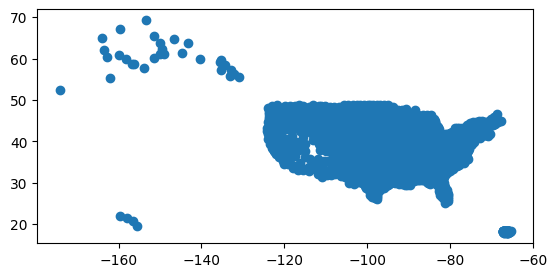

In [9]:
gdf.plot()

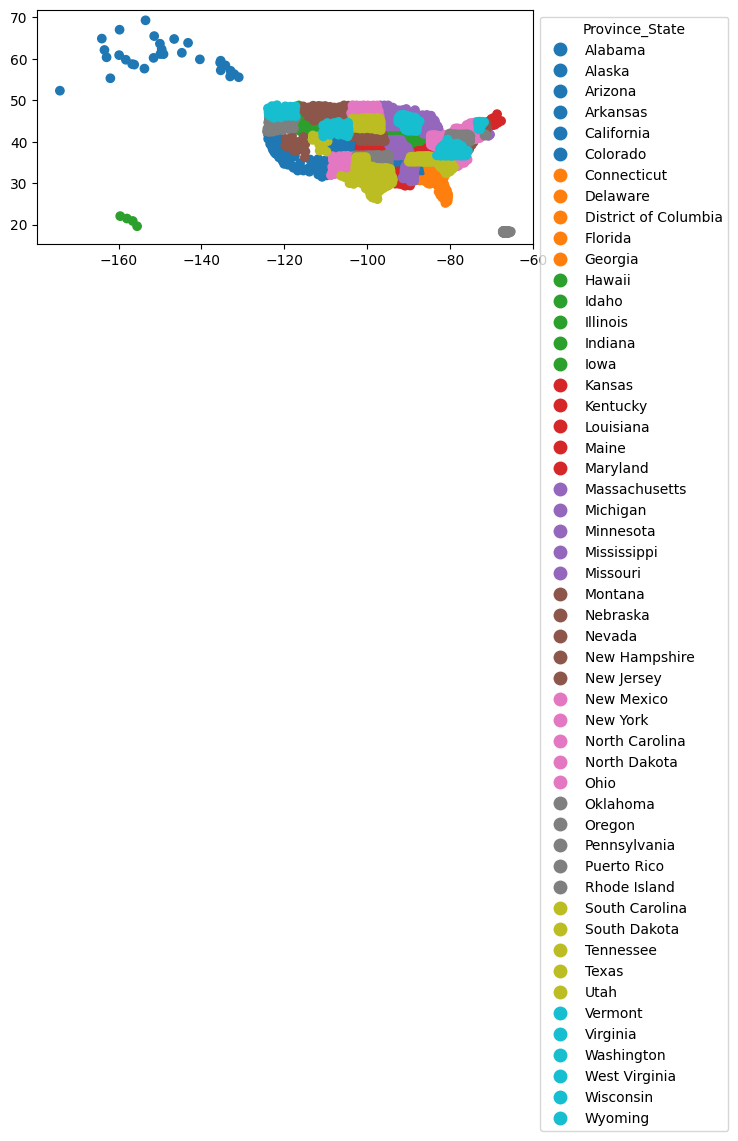

In [10]:
# set the legend outside the plot
ax = gdf.plot(column="Province_State", legend=True)
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))
legend.set_title("Province_State")


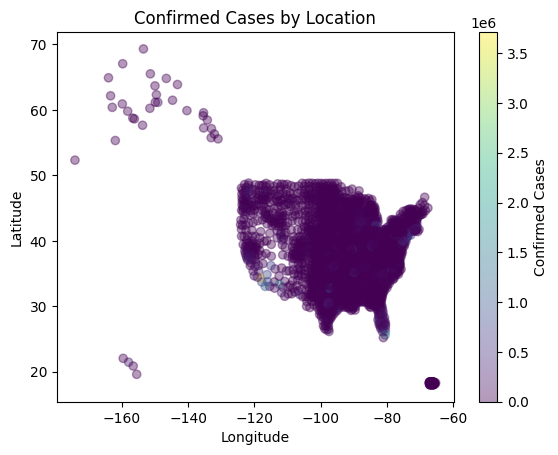

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'Lat', 'Long_', and 'Confirmed' columns to numeric
gdf['Lat'] = pd.to_numeric(gdf['Lat'], errors='coerce')
gdf['Long_'] = pd.to_numeric(gdf['Long_'], errors='coerce')
gdf['Confirmed'] = pd.to_numeric(gdf['Confirmed'], errors='coerce')

# Scatter plot with colors based on 'Confirmed' cases
plt.scatter(gdf['Long_'], gdf['Lat'], c=gdf['Confirmed'], cmap='viridis', alpha=0.4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Confirmed Cases by Location')

# Add a colorbar to the plot
cbar = plt.colorbar()
cbar.set_label('Confirmed Cases')

plt.show()

In [12]:
from numpy.ma.extras import setdiff1d
import numpy as np
%matplotlib inline
from collections import namedtuple

# Define a named tuple to store outlier information
Outlier = namedtuple('Outlier', ['Index', 'Confirmed', 'Lat', 'Long_'])

def detect_outliers(data):
    threshold = 3
    mean = np.mean(data['Confirmed'])
    std = np.std(data['Confirmed'])

    outliers = []
    for i, row in data.iterrows():
        z_score = (row['Confirmed'] - mean) / std
        if np.abs(z_score) > threshold:
            outlier = Outlier(i, row['Confirmed'], row['Lat'], row['Long_'])
            outliers.append(outlier)

    return outliers

In [13]:
dataset = pd.DataFrame({
    'Lat': pd.to_numeric(gdf['Lat'], errors='coerce'),
    'Long_': pd.to_numeric(gdf['Long_'], errors='coerce'),
    'Confirmed': pd.to_numeric(gdf['Confirmed'], errors='coerce')
})

outliers_pt = detect_outliers(dataset)

In [14]:
outliers_pt

[Outlier(Index=107, Confirmed=1530296.0, Lat=33.34835867, Long_=-112.4918154),
 Outlier(Index=193, Confirmed=402160.0, Lat=37.64629437, Long_=-121.8929271),
 Outlier(Index=211, Confirmed=3710586.0, Lat=34.30828379, Long_=-118.2282411),
 Outlier(Index=222, Confirmed=788663.0, Lat=33.70147516, Long_=-117.7645998),
 Outlier(Index=226, Confirmed=776620.0, Lat=33.74314981, Long_=-115.9933578),
 Outlier(Index=227, Confirmed=409095.0, Lat=38.45106826, Long_=-121.3425374),
 Outlier(Index=229, Confirmed=745179.0, Lat=34.84060306, Long_=-116.1774685),
 Outlier(Index=230, Confirmed=1067659.0, Lat=33.03484597, Long_=-116.7365326),
 Outlier(Index=236, Confirmed=497526.0, Lat=37.23104908, Long_=-121.6970462),
 Outlier(Index=338, Confirmed=774980.0, Lat=26.15184651, Long_=-80.48725556),
 Outlier(Index=360, Confirmed=479640.0, Lat=27.9276559, Long_=-82.32013172),
 Outlier(Index=375, Confirmed=1552197.0, Lat=25.6112362, Long_=-80.55170587),
 Outlier(Index=380, Confirmed=475796.0, Lat=28.51367621, Long_

In [15]:
outlier_size = len(outliers_pt)
print("Size of outliers array:", outlier_size)

Size of outliers array: 36


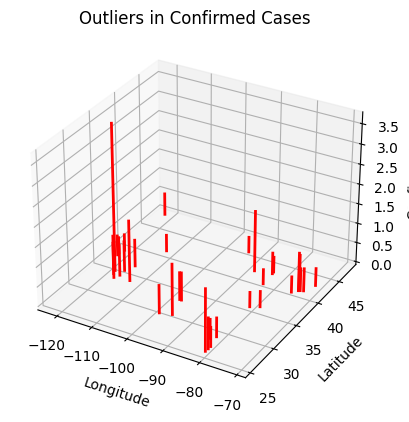

In [16]:
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D toolkit

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

dataset = pd.DataFrame({
    'Lat': pd.to_numeric(gdf['Lat'], errors='coerce'),
    'Long_': pd.to_numeric(gdf['Long_'], errors='coerce'),
    'Confirmed': pd.to_numeric(gdf['Confirmed'], errors='coerce')
})

outliers_pt = detect_outliers(dataset)

# Plot height lines for outliers
for outlier in outliers_pt:
    ax.plot([outlier.Long_, outlier.Long_], [outlier.Lat, outlier.Lat], [0, outlier.Confirmed], color='red', label='Height Line', linewidth=2)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Confirmed')
ax.set_title('Outliers in Confirmed Cases')
plt.show()

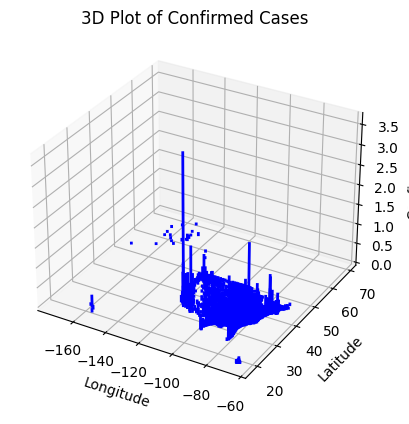

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

gdf['Lat'] = pd.to_numeric(gdf['Lat'], errors='coerce')
gdf['Long_'] = pd.to_numeric(gdf['Long_'], errors='coerce')
gdf['Confirmed'] = pd.to_numeric(gdf['Confirmed'], errors='coerce')

for _, row in gdf.iterrows():
    ax.plot([row['Long_'], row['Long_']], [row['Lat'], row['Lat']], [0, row['Confirmed']], color='blue', label='Height Line', linewidth=2)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Confirmed')
ax.set_title('3D Plot of Confirmed Cases')
plt.show()

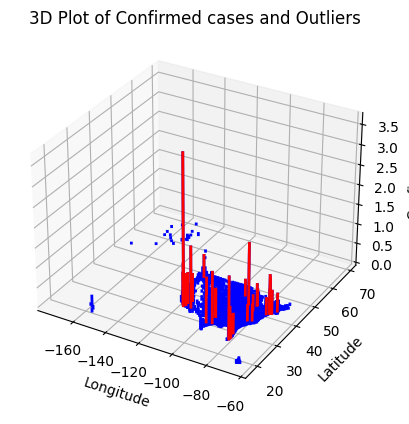

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

gdf['Lat'] = pd.to_numeric(gdf['Lat'], errors='coerce')
gdf['Long_'] = pd.to_numeric(gdf['Long_'], errors='coerce')
gdf['Confirmed'] = pd.to_numeric(gdf['Confirmed'], errors='coerce')

dataset = pd.DataFrame({
    'Lat': pd.to_numeric(gdf['Lat'], errors='coerce'),
    'Long_': pd.to_numeric(gdf['Long_'], errors='coerce'),
    'Confirmed': pd.to_numeric(gdf['Confirmed'], errors='coerce')
})

outliers_pt = detect_outliers(dataset)

# Plot height lines for all data points in blue
for _, row in gdf.iterrows():
    ax.plot([row['Long_'], row['Long_']], [row['Lat'], row['Lat']], [0, row['Confirmed']], color='blue', label='Height Line', linewidth=2)

# Plot height lines for outliers in red
for outlier in outliers_pt:
    ax.plot([outlier.Long_, outlier.Long_], [outlier.Lat, outlier.Lat], [0, outlier.Confirmed], color='red', label='Outlier', linewidth=2)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Confirmed')
ax.set_title('3D Plot of Confirmed cases and Outliers')
plt.show()